In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%matplotlib notebook

# Generate Synthetic Data

In [ ]:
numSyntheticSamples = 100000
syntheticDataRange = np.linspace( 0, np.pi*numSyntheticSamples/10.0, numSyntheticSamples)
syntheticData = np.sin( syntheticDataRange ) + np.random.randint( -1, 1, size = numSyntheticSamples ) * 1/2.

In [ ]:
if syntheticData.ndim < 2:
    syntheticData = np.expand_dims(syntheticData, axis=1)

In [ ]:
syntheticData.shape

In [ ]:
plt.figure()
plt.plot(syntheticData[:500])

# Define hyperparameters

In [ ]:
# of samples per sensor for the micro model [sliding window of ~2.5 hrs]
hParams = {}
hParams['windowSamples'] = 30
hParams['nSensors'] = 1
hParams['overlapPercentage'] = .99
hParams['advanceSamples'] = ( hParams['windowSamples'] - int( np.floor( hParams['windowSamples'] * hParams['overlapPercentage'] ) ))

# Split into train and test set (.25 test data)

In [ ]:
def train_test_split (x, testDataRatio = .25, trainDataAtStart = True):
    assert x.ndim > 1
    if trainDataAtStart:
        splitIndex = int( ( 1.0 - testDataRatio) * x.shape[0] )    
        
        xTrain = x[ 0:splitIndex, :]
        xTest = x[ splitIndex:, :]
    else:
        splitIndex = int( testDataRatio * x.shape[0] )
        xTest = x[ 0:splitIndex, :]
        xTrain = x[ splitIndex:, :]
        
    return xTrain, xTest

In [ ]:
trainSplit, testSplit = train_test_split( syntheticData )

In [ ]:
syntheticData.shape

In [ ]:
trainSplit.shape

In [ ]:
testSplit.shape

# Normalize data ( 0 mean, unit standard deviation )

In [ ]:
# find normalization statistics
trainMeans = np.mean(trainSplit, axis=0)
trainSTDevs = np.std(trainSplit, axis=0)
print(trainMeans); print(trainSTDevs)

# normalize [ in place / overwrite ]
normalizedTrainData = (trainSplit - trainMeans) / (trainSTDevs + .0001)
normalizedTestData = (testSplit - trainMeans) / (trainSTDevs + .0001)

# Generate shuffled windows

In [ ]:
def reshape_into_shuffled_data_windows ( x, windowSize, advanceSamples ):
    nWindows = int( np.floor( (x.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    # shuffle indexes
    shuffledWindowInds = np.arange(nWindows)
    np.random.shuffle(shuffledWindowInds)    
        
    nSensors = x.shape[1]
    outputMatrix = np.zeros((nWindows, windowSize * nSensors))
    
    # update data matrix on a row by row basis (choosing shuffled windows per row)
    for iWindow in range(nWindows):
        startIndex = shuffledWindowInds[iWindow] * advanceSamples
        endIndex = startIndex + windowSize
        
        # flatten/interleave sensor values
        for iSensor in range(nSensors):
            outputMatrix[iWindow, iSensor::nSensors] = x[startIndex:endIndex, iSensor]
    
    return outputMatrix, shuffledWindowInds


In [ ]:
trainMatrix, trainShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTrainData, hParams['windowSamples'], hParams['advanceSamples'])
testMatrix, testShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTestData, hParams['windowSamples'], hParams['advanceSamples'])

viz_flag = 1
if viz_flag:
    plt.figure()
    plt.plot(trainMatrix[200,:])


In [ ]:
trainMatrix.shape

In [ ]:
testMatrix.shape

# ML/DL Imports

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import metrics
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Model definition

In [ ]:
hParams['inputOutputDimensionality'] = int( hParams['windowSamples'] * hParams['nSensors'] ) 
assert hParams['inputOutputDimensionality'] == trainMatrix.shape[1]



In [ ]:
# Define model
model = Sequential()
model.add( Dense( 15, input_dim = hParams['inputOutputDimensionality'], activation = 'linear'))
model.add( Dense( 5, activation = 'sigmoid'))
model.add( Dense( 15, activation = 'sigmoid'))
model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear',))
model.summary()

In [ ]:
import nnViz
plt.figure()
nnViz.visualize_model(model)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
checkpointer = ModelCheckpoint( filepath = 'synthetic_sin_weights_2.hdf5', verbose=1, save_best_only = True)

history = model.fit( trainMatrix, trainMatrix,
               batch_size = 256, epochs = 200,
               shuffle = True,
               #callbacks = [early_stopping, checkpointer],
               validation_data = (testMatrix, testMatrix) )

In [ ]:
plt.figure()
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )

# Load best model weights

In [148]:
model.load_weights("synthetic_sin_weights_2.hdf5")
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

# Plot raw vs predicted 

In [149]:
def windowed_predict(data, windowSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((data.shape[0], data.shape[1]))
    
    for iWindow in range(nWindows):
        print(iWindow)
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[dataStartIndex:dataEndIndex] = np.transpose(predictedWindow)
        
    return predicted

# Inject Anomalies & Predict

<IPython.core.display.Javascript object>


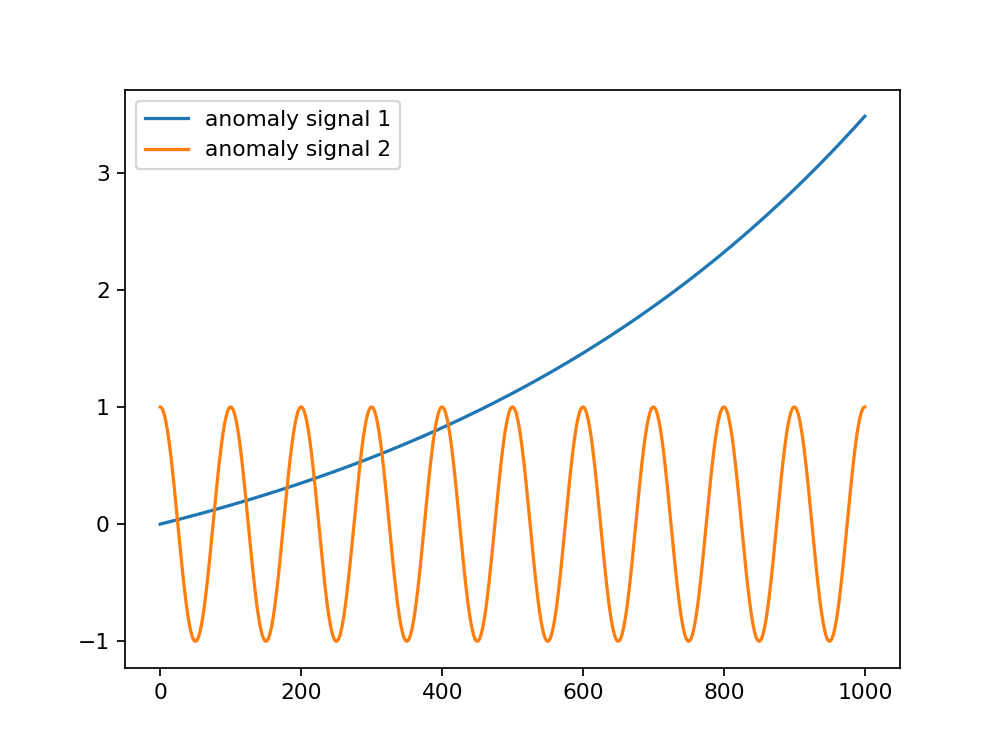

In [150]:
anomalySignal1 = np.exp(np.linspace(0, 1.5, 1000)) - 1
anomalySignal2 = np.cos(np.linspace(0,2*np.pi * 10, 1000))

anomalySignal1 = np.expand_dims(anomalySignal1, axis=1)
anomalySignal2 = np.expand_dims(anomalySignal2, axis=1)

plt.figure()
plt.plot(anomalySignal1)
plt.plot(anomalySignal2)

plt.legend(['anomaly signal 1', 'anomaly signal 2'])

In [151]:
startIndex = 0
endIndex = 1000
len(anomalySignal1)

1000

In [171]:
targetData = []
targetData = np.concatenate( ( normalizedTestData[startIndex:endIndex], anomalySignal1, \
                               normalizedTestData[startIndex:endIndex], anomalySignal2 ) )

anomalousInds_1 = np.arange(1000/hParams['windowSamples'], 2000/hParams['windowSamples'], dtype=int)
anomalousInds_2 = np.arange(int(3000/hParams['windowSamples']), int(4000/hParams['windowSamples']), dtype=int)

In [176]:
predictedData = windowed_predict ( targetData, hParams['inputOutputDimensionality'])
error = np.sqrt((targetData - predictedData)**2)

number of windows: 133
0


ValueError: could not broadcast input array from shape (5,1) into shape (30,1)

<IPython.core.display.Javascript object>


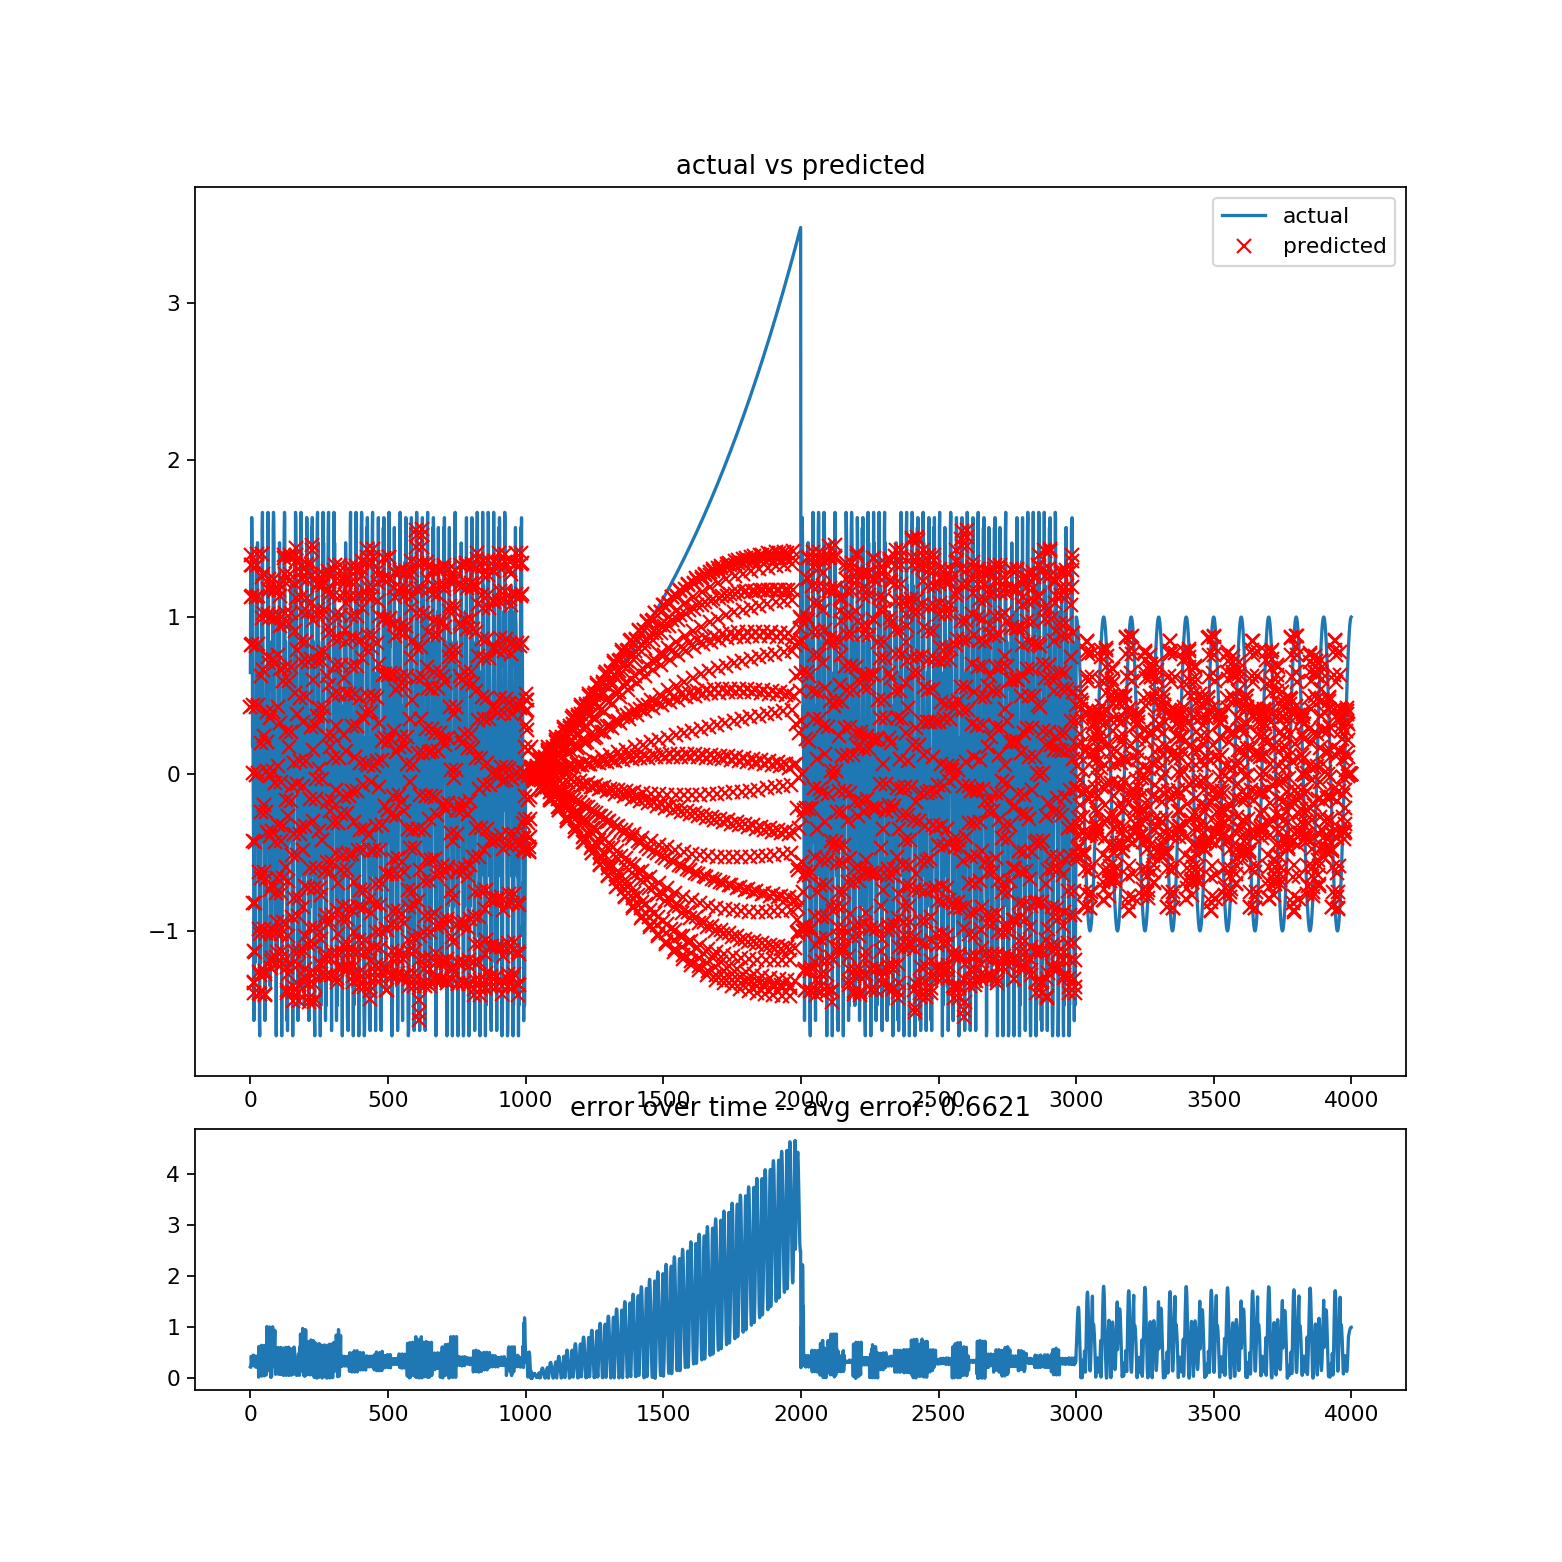

In [156]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)

ax1.plot(targetData)
ax1.plot(predictedData, 'rx')
ax1.set_title('actual vs predicted')
ax1.legend(['actual', 'predicted'])

ax2.plot(error)
ax2.set_title('error over time -- avg error: ' + str(round(np.mean(error),4)))

## Remove last two layers [ focus on bottleneck activations ]

In [157]:
print(len(model.layers))

4


In [158]:
model.pop()
model.pop()

In [159]:
print(len(model.layers))

2


<IPython.core.display.Javascript object>


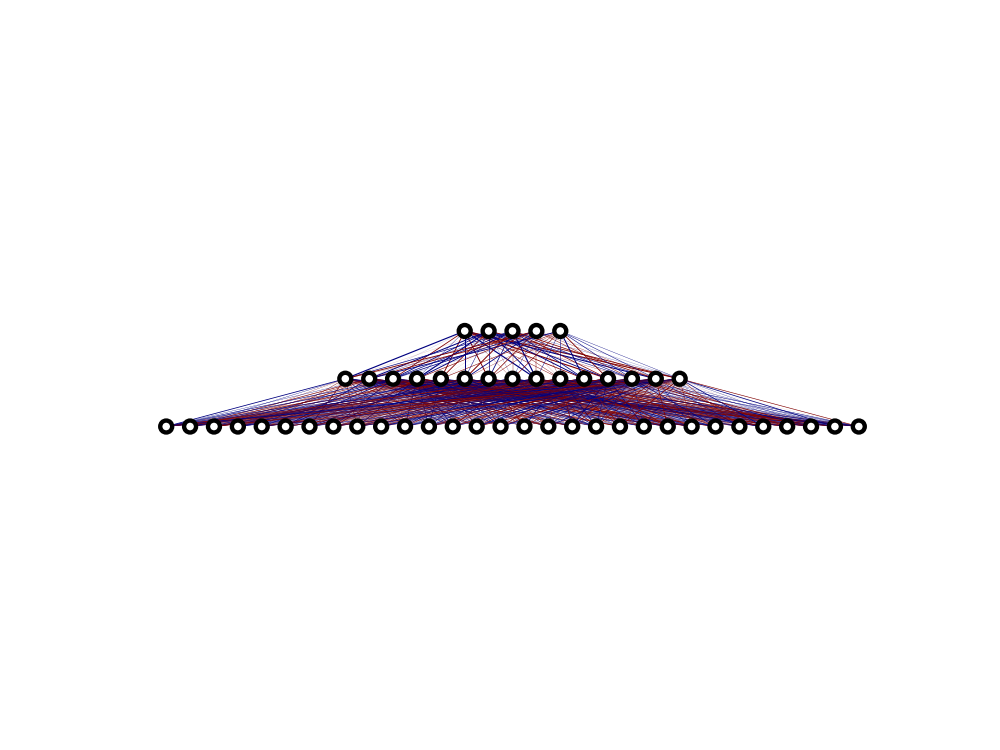

In [160]:
import nnViz
plt.figure()
nnViz.visualize_model(model)

In [161]:
model.compile(optimizer = 'adam', loss = 'mse')

#TODO : no overlaps

In [162]:
def windowed_predict_bottleneck_activation (data, windowSize, bottleneckSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((nWindows, bottleneckSize))
    
    for iWindow in range(nWindows):
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[iWindow, :] = predictedWindow[0]
        
        
    return predicted

In [163]:
bottleNeckSize = model.layers[-1].get_config()['units']
bottleneckActivations = windowed_predict_bottleneck_activation (targetData, hParams['inputOutputDimensionality'], bottleNeckSize)

number of windows: 133


In [164]:
from sklearn.manifold import TSNE

embeddedBottleneckActivations = TSNE(n_components = 2, perplexity = 10, learning_rate = 100, method='exact', verbose = 1).fit_transform(bottleneckActivations)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 133 / 133
[t-SNE] Mean sigma: 0.111642
[t-SNE] KL divergence after 100 iterations with early exaggeration: 11.148747
[t-SNE] Error after 775 iterations: 11.148747


<IPython.core.display.Javascript object>


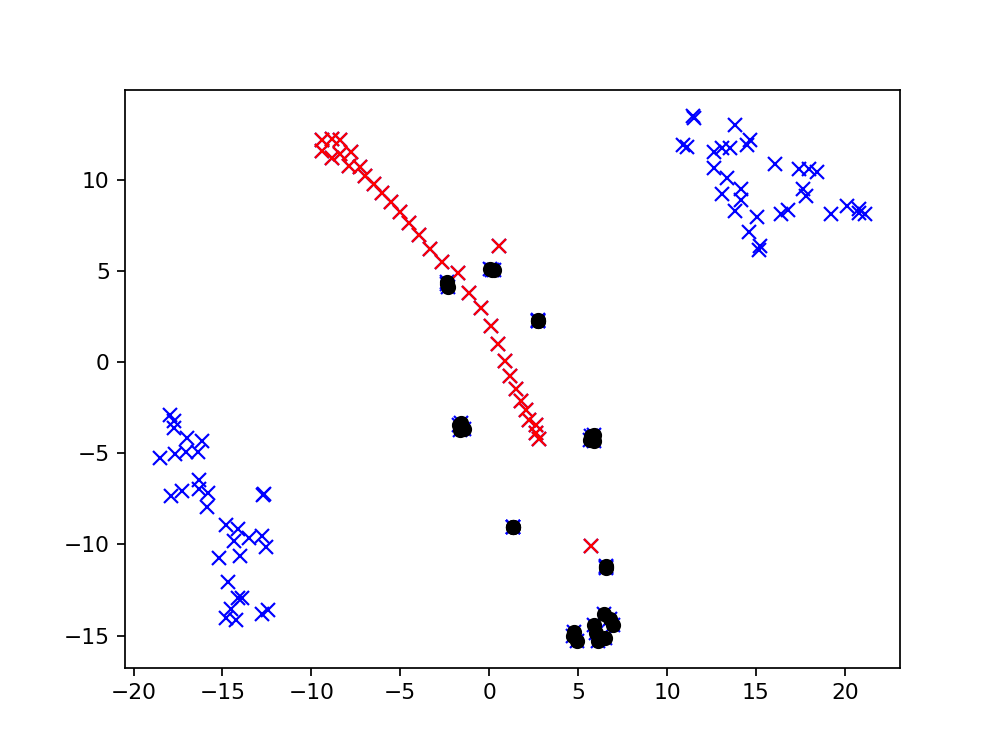

In [177]:
plt.figure()
plt.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], 'bx')
plt.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], 'rx')
plt.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], 'ko')


In [178]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components = 3)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

<IPython.core.display.Javascript object>


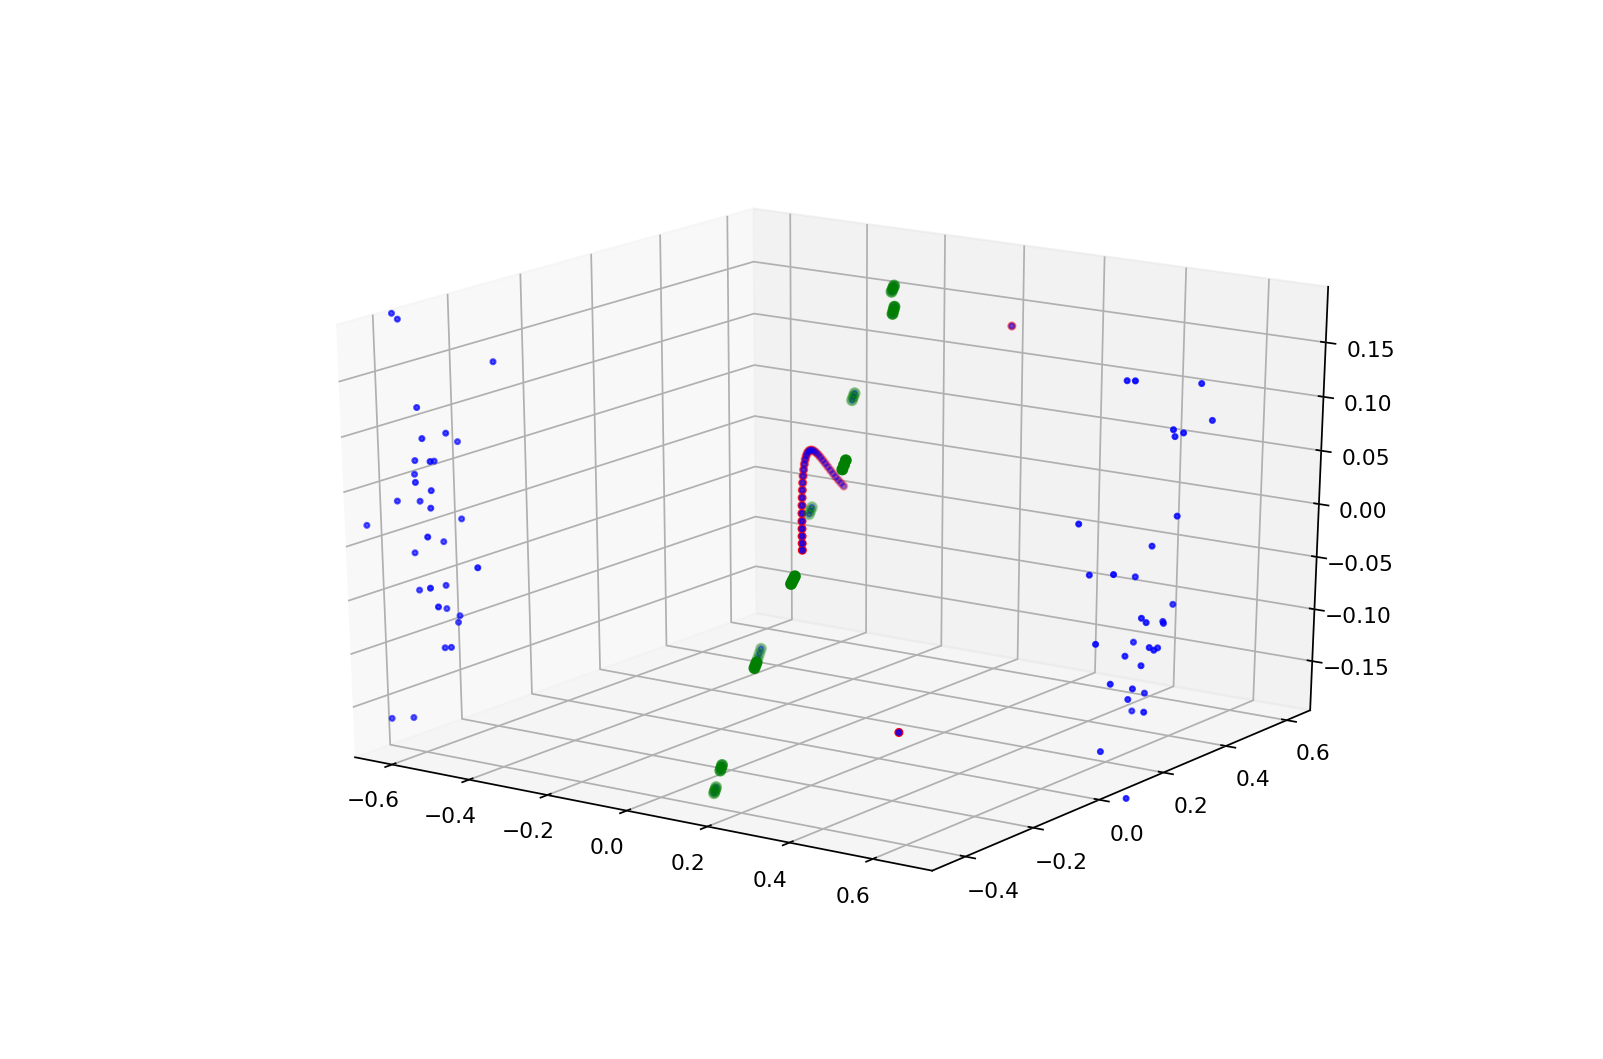

In [194]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], color='b', s=5)
ax.scatter(PCA_bottleneckActivations[anomalousInds_1, 0], PCA_bottleneckActivations[anomalousInds_1, 1], PCA_bottleneckActivations[anomalousInds_1, 2], color='r', s=10)
ax.scatter(PCA_bottleneckActivations[anomalousInds_2, 0], PCA_bottleneckActivations[anomalousInds_2, 1], PCA_bottleneckActivations[anomalousInds_2, 2], color='g')

In [195]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [196]:
import mpld3
from mpld3 import plugins, utils

In [199]:
%matplotlib ipympl
# https://github.com/matplotlib/jupyter-matplotlib

In [200]:
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>


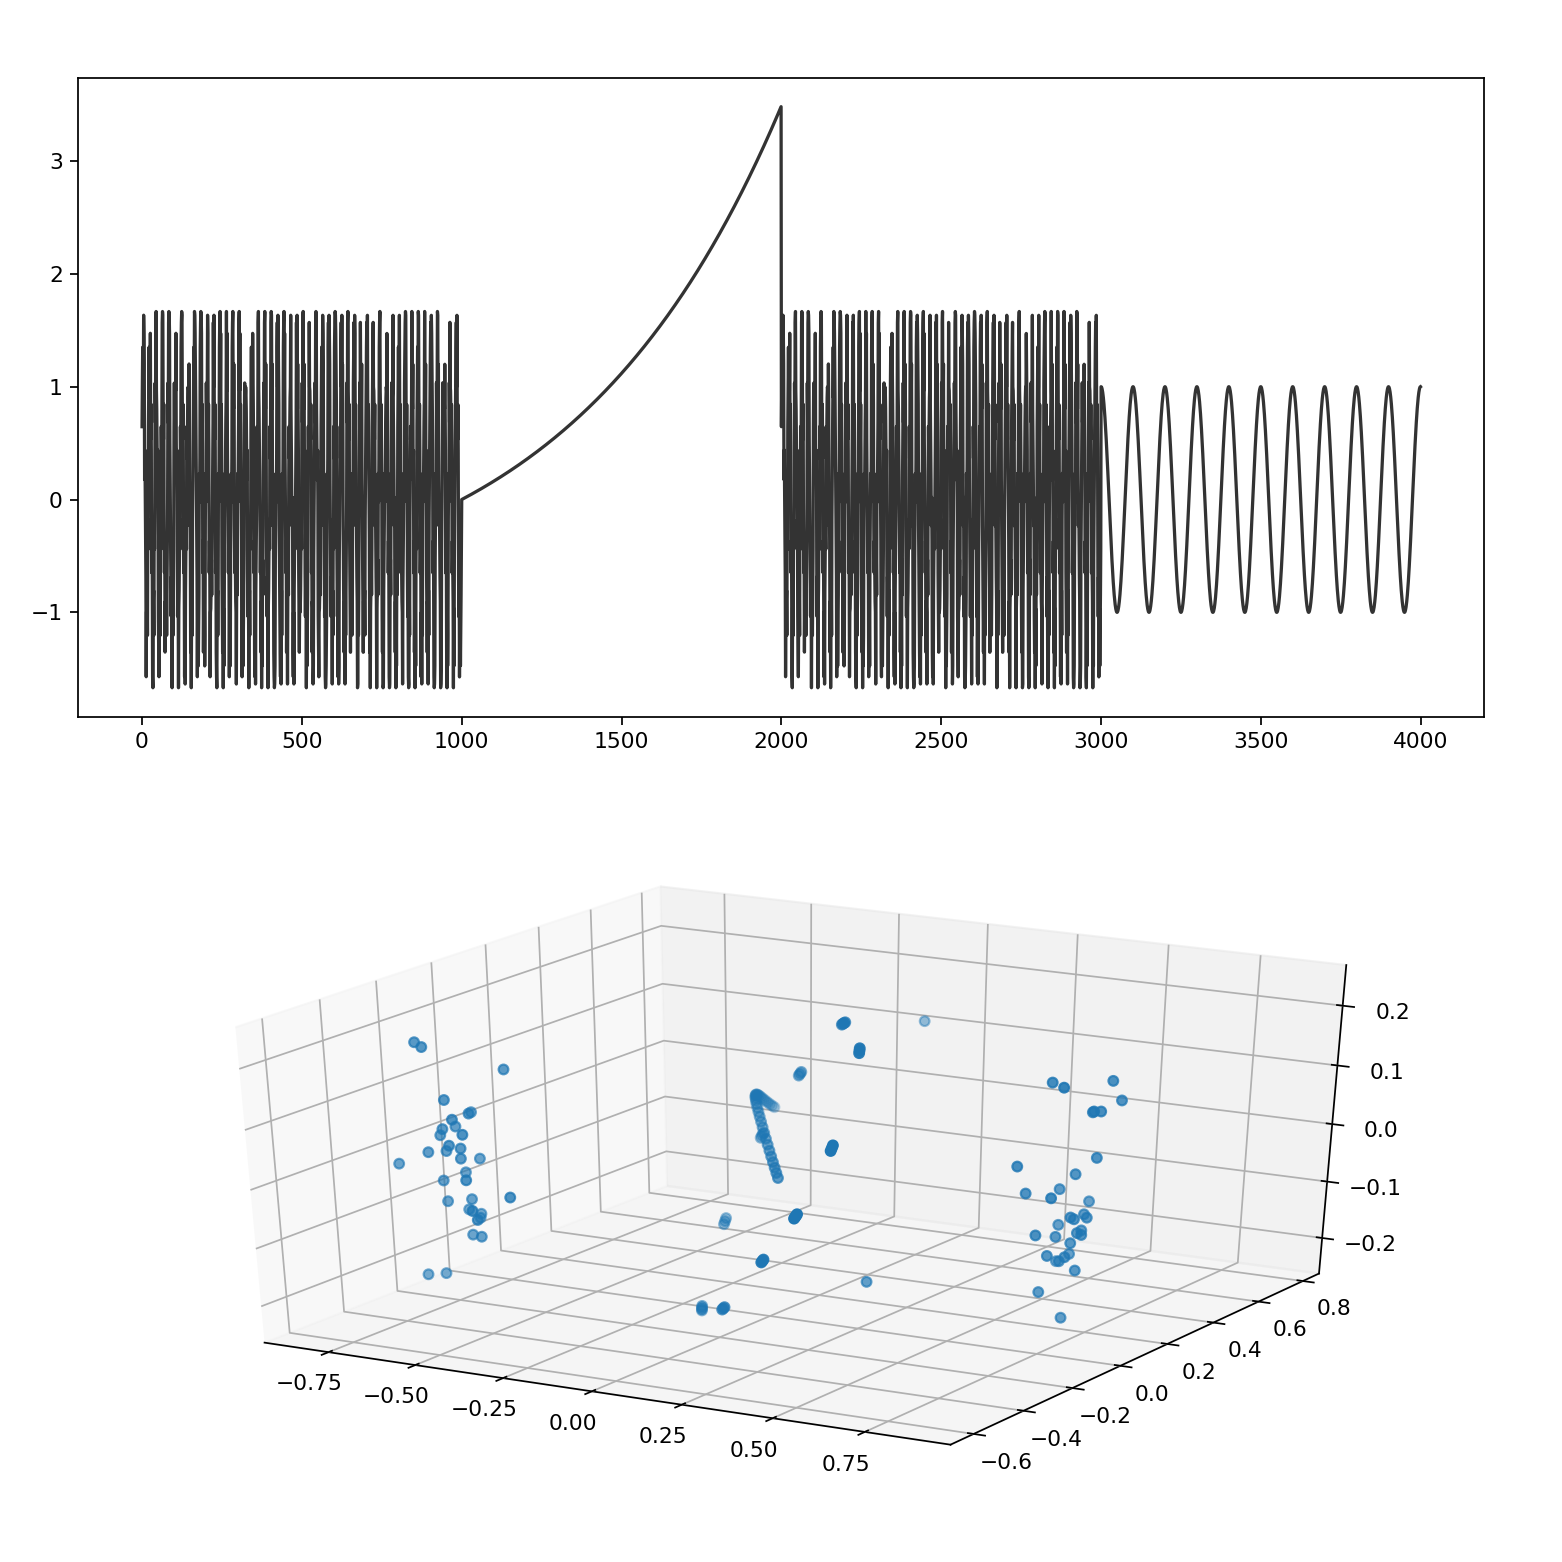

In [227]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust( left = 0.05, right = 0.95, top = 0.95, bottom = 0.05, wspace = 0.1 )
ax1 = plt.subplot( 2, 1, 1 )

ax1.plot( range(len(targetData)), targetData, color=(.2,.2,.2), picker = 1 )

ax2 = plt.subplot( 2, 1, 2 )
ax2.plot ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,1], 'o', picker = 2 )
#ax2.scatter ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], picker = 2 )

In [230]:
def updateRawPlot ( ind ):
    print(' index range:  ' + str(int((ind-2)*30)) + ', '+ str(int((ind+2)*30)))
    ax1.plot( list(range(int((ind-2)*30),int((ind+2)*30))), targetData[ int((ind-2)*30):int((ind+2)*30) ] )

In [231]:
#ax.scatter(list(range(100)),np.random.rand(100))#, 'o', picker=5)  # 5 points tolerance
#ax.plot(np.random.rand(100), 'o', picker=5)  # 5 points toleranc
def on_pick(event):
    if event.mouseevent.inaxes == ax2:          
        eventArtist = event.artist
        #xdata, ydata = eventArtist.get_data()
        ind = event.ind
        updateRawPlot( ind )
        #print('on pick line:', ind, np.array([xdata[ind], ydata[ind]]).T)
    
cid = fig.canvas.mpl_connect('pick_event', on_pick)
#plt.show()